<a href="https://colab.research.google.com/github/otkata19/competition/blob/main/lgbm_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [2]:
%matplotlib inline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Load Files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [6]:
ls

 data_explanation.xlsx   signate/
 data.zip                submission.csv
 detectron2演習.ipynb    test.csv
 kaggle.json             train.csv
 kaggle_test.ipynb       tutorial_forPeakersNLPOnline202002_hata.ipynb
 lgbm_baseline.ipynb     Untitled0.ipynb
 media.ipynb            '確認問題(修正)'/
 pytorch_test.ipynb      論文実装のためのPytorch.ipynb
 sample_submission.csv


In [7]:
df_exp = pd.read_csv("sample_submission.csv")

In [8]:
fparh = Path('./')

train_fname = 'train.csv'
test_fname = 'test.csv'
sub_fname = 'sample_submission.csv'

In [9]:
df_train = pd.read_csv(fparh / train_fname)
df_test = pd.read_csv(fparh / test_fname)
submission = pd.read_csv(fparh / sub_fname)

print('df_train shape :', df_train.shape)
print('df_test shape :', df_test.shape)
print('submission shape :', submission.shape)

df_train shape : (40000, 20)
df_test shape : (8522, 19)
submission shape : (8522, 6)


In [ ]:
df_train.head()

In [ ]:
df_test.head()

## Distribution of Target

In [10]:
df_train['fav_novel_cnt_bin'].value_counts()

0    18646
1    14363
2     4320
3     1857
4      814
Name: fav_novel_cnt_bin, dtype: int64

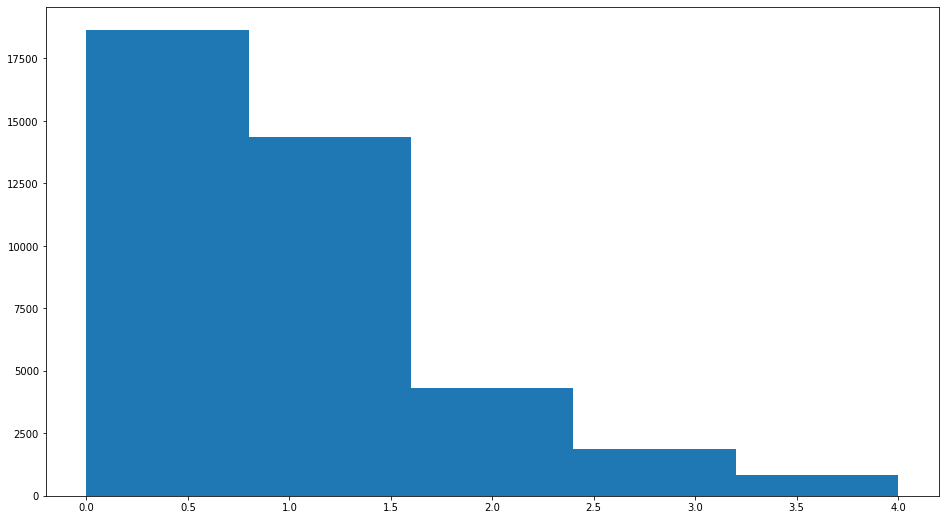

In [ ]:
fig = plt.figure(figsize=(16, 9))
plt.hist(df_train['fav_novel_cnt_bin'], bins=5)
plt.show()

## Modeling

In [11]:
def fit(tr_x, tr_y, va_x, va_y, tr_w=None, va_w=None):
    """
    model training
  
    Parameters
    ----------
    tr_x: pd.DataFrame
    tr_y: pd.DataFrame
    va_x: pd.DataFrame
    va_y: pd.DataFrame

    Returns
    ----------
    model:
        - 学習済みモデル
    va_pred: 
        - 検証データの予測結果
    """ 
    # パラメータの設定
    params = {
        'objective': 'multiclass',  
        'boosting_type': 'gbdt',
        'metrics': 'multi_logloss',
        'num_class': 5,
        'seed': 777,
        'learning_rate': 0.01,
        'n_jobs': -1,
        'verbose': -1
        }

    # 学習セットを作成
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        train_set=lgb_train, # トレーニングデータの指定
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        early_stopping_rounds = 100,
        verbose_eval = 20
        )
    
    # 検証データの予測確率
    va_pred = model.predict(va_x)

    return model, va_pred

In [12]:
def scoring(y_true, y_prob):
    """Multi-class logloss"""
    return log_loss(y_true, y_prob)

In [13]:
df_train['userid']

0           9904
1           6527
2          13882
3          13920
4          12136
          ...   
39995    1964264
39996    2180545
39997    2212561
39998     535814
39999    1772298
Name: userid, Length: 40000, dtype: int64

In [68]:
# 値が全て同じカラムとobject型のカラムは使用しない
drop_lst = ['end', 'isstop']
# object_lst = ['ncode', 'general_firstup', 'title', 'story', 'keyword', 'writer']
# object_lst = ['ncode', 'general_firstup', 'title', 'story', 'keyword', 'writer', 'iszankoku', 'istensei', 'istenni', 'isgl', 'isbl', 'pc_or_k']
object_lst = ['ncode', 'general_firstup', 'title', 'story', 'keyword', 'writer', 'iszankoku', 'istensei', 'istenni', 'isgl', 'isbl', 'pc_or_k', 'biggenre', 'isr15']

df_train_numeric = df_train.drop(drop_lst, axis=1)
df_train_numeric = df_train_numeric.drop(object_lst, axis=1)

df_test_numeric = df_test.drop(drop_lst, axis=1)
df_test_numeric = df_test_numeric.drop(object_lst, axis=1)

df_train_numeric.head()

,userid,genre,novel_type,fav_novel_cnt_bin
0,9904,402,1,1
1,6527,401,1,2
2,13882,403,1,3
3,13920,402,1,1
4,12136,401,1,1


In [69]:
# 説明変数,目的変数を分割
X = df_train_numeric.drop('fav_novel_cnt_bin', axis=1)
y = df_train_numeric['fav_novel_cnt_bin']

In [70]:
df_pred = pd.DataFrame(index=X.index, columns=['proba_0', 'proba_1', 'proba_2',	'proba_3', 'proba_4'])
df_pred

,proba_0,proba_1,proba_2,proba_3,proba_4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
39995,NaN,NaN,NaN,NaN,NaN
39996,NaN,NaN,NaN,NaN,NaN
39997,NaN,NaN,NaN,NaN,NaN
39998,NaN,NaN,NaN,NaN,NaN


In [71]:
y

0        1
1        2
2        3
3        1
4        1
        ..
39995    2
39996    0
39997    0
39998    2
39999    0
Name: fav_novel_cnt_bin, Length: 40000, dtype: int64

In [73]:
X.tail()

,userid,genre,novel_type
39995,1964264,9903,2
39996,2180545,102,2
39997,2212561,307,2
39998,535814,201,2
39999,1772298,302,2


In [74]:
y[14819:14829]

14819    0
14820    1
14821    0
14822    0
14823    0
14824    0
14825    0
14826    1
14827    0
14828    1
Name: fav_novel_cnt_bin, dtype: int64

In [75]:
models = []
df_pred = pd.DataFrame(index=X.index, columns=['proba_0', 'proba_1', 'proba_2',	'proba_3', 'proba_4'])

# トレーニングデータ,テストデータの分割
skf = StratifiedKFold(n_splits=5)
for train_index, valid_index in skf.split(X, y):
    print('---CV{i}---')
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_valid, y_valid = X.loc[valid_index], y.loc[valid_index]
    # モデルの学習
    model, va_pred = fit(X_train, y_train, X_valid, y_valid) 
    # モデルの格納
    models.append(model)
    # 検証データの予測結果を格納
    df_pred.loc[valid_index] = va_pred

---CV{i}---
Training until validation scores don't improve for 100 rounds.
[20]	train's multi_logloss: 1.12403	valid's multi_logloss: 1.15525
[40]	train's multi_logloss: 1.08209	valid's multi_logloss: 1.13279
[60]	train's multi_logloss: 1.05109	valid's multi_logloss: 1.11667
[80]	train's multi_logloss: 1.02708	valid's multi_logloss: 1.10525
[100]	train's multi_logloss: 1.00816	valid's multi_logloss: 1.09637
[120]	train's multi_logloss: 0.992913	valid's multi_logloss: 1.0884
[140]	train's multi_logloss: 0.980467	valid's multi_logloss: 1.08152
[160]	train's multi_logloss: 0.97016	valid's multi_logloss: 1.07646
[180]	train's multi_logloss: 0.961238	valid's multi_logloss: 1.07223
[200]	train's multi_logloss: 0.953575	valid's multi_logloss: 1.06889
[220]	train's multi_logloss: 0.946785	valid's multi_logloss: 1.0661
[240]	train's multi_logloss: 0.940498	valid's multi_logloss: 1.0635
[260]	train's multi_logloss: 0.935118	valid's multi_logloss: 1.0616
[280]	train's multi_logloss: 0.930411	vali

In [61]:
models = []
df_pred = pd.DataFrame(index=X.index, columns=['proba_0', 'proba_1', 'proba_2',	'proba_3', 'proba_4'])

# トレーニングデータ,テストデータの分割
skf = StratifiedKFold(n_splits=5)
for train_index, valid_index in skf.split(X, y):
    print('---CV{i}---')
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_valid, y_valid = X.loc[valid_index], y.loc[valid_index]
    # モデルの学習
    model, va_pred = fit(X_train, y_train, X_valid, y_valid) 
    # モデルの格納
    models.append(model)
    # 検証データの予測結果を格納
    df_pred.loc[valid_index] = va_pred

---CV{i}---
Training until validation scores don't improve for 100 rounds.
[20]	train's multi_logloss: 1.12308	valid's multi_logloss: 1.15106
[40]	train's multi_logloss: 1.08041	valid's multi_logloss: 1.12625
[60]	train's multi_logloss: 1.04883	valid's multi_logloss: 1.10962
[80]	train's multi_logloss: 1.02439	valid's multi_logloss: 1.09778
[100]	train's multi_logloss: 1.00489	valid's multi_logloss: 1.08844
[120]	train's multi_logloss: 0.989068	valid's multi_logloss: 1.07997
[140]	train's multi_logloss: 0.976052	valid's multi_logloss: 1.07269
[160]	train's multi_logloss: 0.965112	valid's multi_logloss: 1.06664
[180]	train's multi_logloss: 0.955847	valid's multi_logloss: 1.06188
[200]	train's multi_logloss: 0.947777	valid's multi_logloss: 1.05822
[220]	train's multi_logloss: 0.94072	valid's multi_logloss: 1.0545
[240]	train's multi_logloss: 0.934463	valid's multi_logloss: 1.05217
[260]	train's multi_logloss: 0.928825	valid's multi_logloss: 1.05045
[280]	train's multi_logloss: 0.923729	v

In [24]:
models

In [25]:
# モデルの保存
import pickle

# カレントディレクトリへモデルを保存
file = 'trained_model.pkl'
pickle.dump(models, open(file, 'wb'))

In [29]:
# モデルの削除
del models

In [32]:
models = pickle.load(open('trained_model.pkl', 'rb'))

In [76]:
df_pred

,proba_0,proba_1,proba_2,proba_3,proba_4
0,0.157765,0.515251,0.265732,0.0546795,0.00657274
1,0.152585,0.494949,0.270058,0.0535997,0.0288087
2,0.224038,0.574108,0.168089,0.0254512,0.00831288
3,0.157765,0.515251,0.265732,0.0546795,0.00657274
4,0.152585,0.494949,0.270058,0.0535997,0.0288087
...,...,...,...,...,...
39995,0.266637,0.621892,0.105949,0.00412839,0.00139314
39996,0.655469,0.278504,0.0373653,0.0271555,0.00150627
39997,0.853185,0.101173,0.0388245,0.00601974,0.000798019
39998,0.456266,0.398277,0.115129,0.0286983,0.00163058


In [77]:
# CVスコア
scoring(df_train['fav_novel_cnt_bin'], df_pred)

1.008591803966645

## Prediction

In [64]:
def predict(models, x):
    """
    prediction
  
    Parameters
    ----------
    models: list
        - trained model
    x: pd.DataFrame

    Returns
    ----------
    result: pd.DataFrame
    """ 
    result = pd.DataFrame(0, index=x.index, columns=['proba_0',	'proba_1', 'proba_2', 'proba_3', 'proba_4'])
    for model in models:
        pred_prob = model.predict(x, num_iteration=model.best_iteration)
        lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
        plt.tight_layout()
        plt.show()
        df_pred = pd.DataFrame(pred_prob, index=x.index, columns=['proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4'])
        result += df_pred
    result = result / 5
    return result

In [65]:
df_test_numeric

,userid,biggenre,genre,novel_type,isr15
0,952106,99,9903,2,0
1,2197141,1,101,2,1
2,2235083,3,302,2,0
3,2236089,1,101,1,0
4,414104,99,9902,2,0
...,...,...,...,...,...
8517,2263100,99,9903,2,0
8518,2254651,3,305,2,0
8519,846989,3,302,2,0
8520,2259847,2,202,2,0


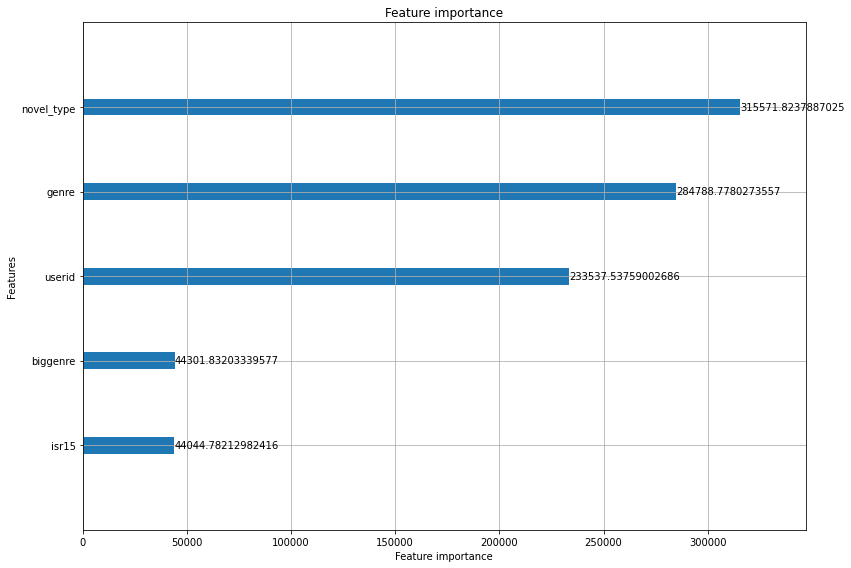

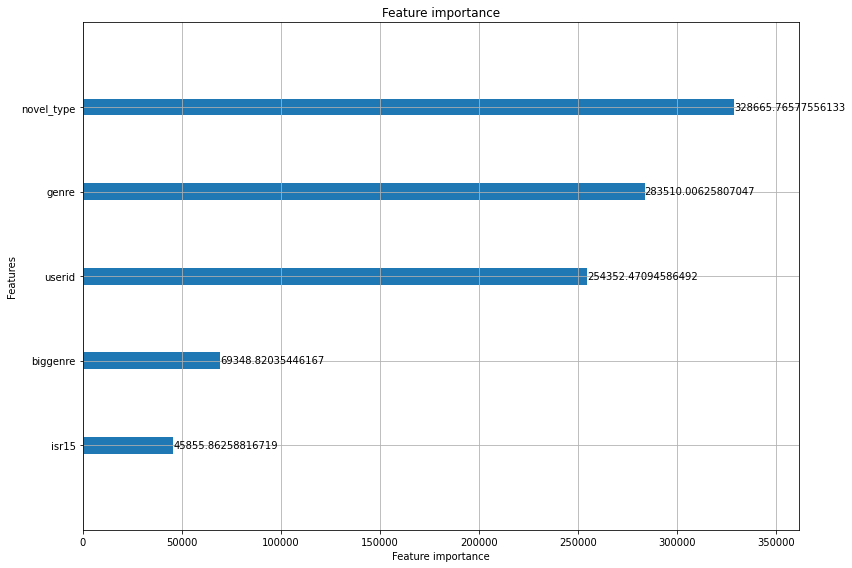

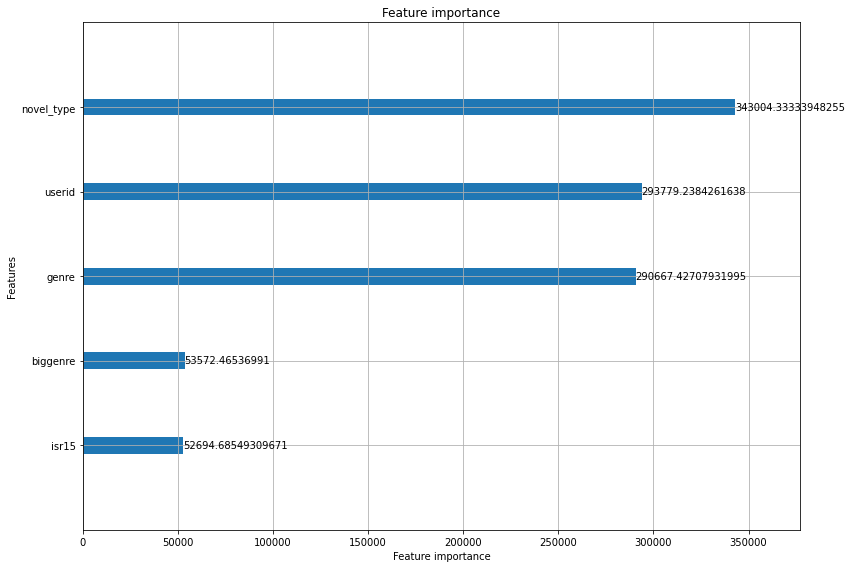

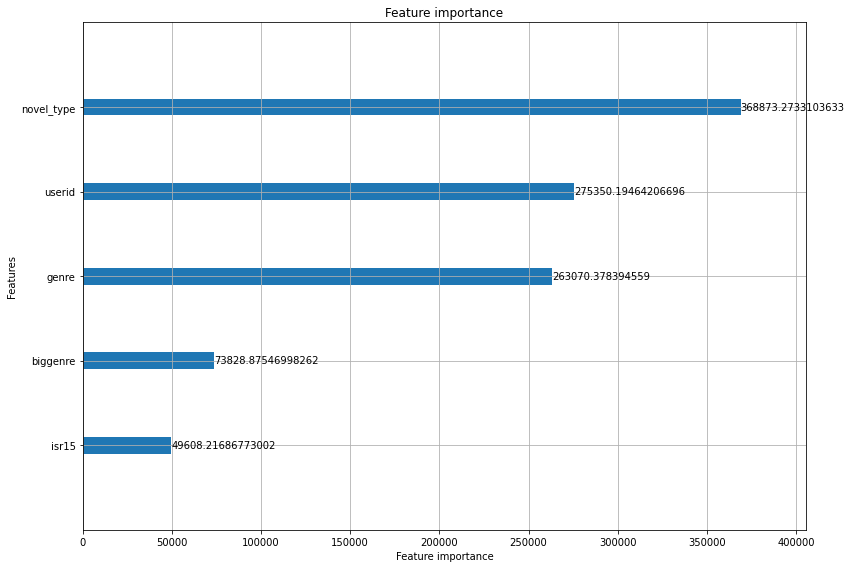

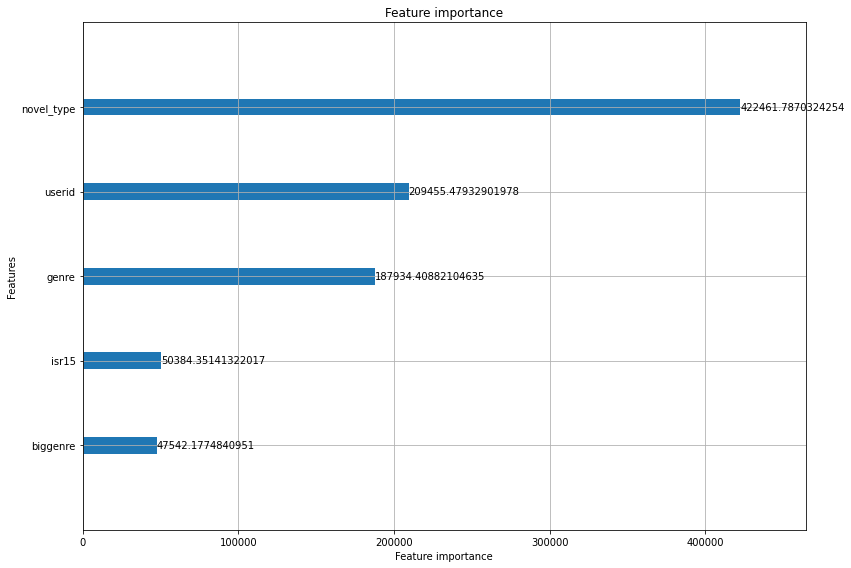

,proba_0,proba_1,proba_2,proba_3,proba_4
0,0.573773,0.387180,0.033470,0.004493,0.001084
1,0.081089,0.223091,0.490011,0.194176,0.011633
2,0.840744,0.147844,0.007345,0.003292,0.000775
3,0.160062,0.281207,0.156332,0.346855,0.055544
4,0.567211,0.387362,0.039176,0.005103,0.001148
...,...,...,...,...,...
8517,0.843147,0.147081,0.006743,0.002257,0.000772
8518,0.769953,0.219764,0.006562,0.002999,0.000723
8519,0.687330,0.262277,0.040561,0.008605,0.001228
8520,0.827999,0.159447,0.008606,0.003191,0.000757


In [66]:
result = predict(models, df_test_numeric)
result

## Create Submission File

In [ ]:
output_fpath = Path('./')
submission.iloc[:, 1:] = result
submission.to_csv(output_fpath / 'submission.csv', header=True, index=None)

In [ ]:
ls

 data_explanation.xlsx   signate/
 data.zip                submission.csv
 detectron2演習.ipynb    test.csv
 kaggle.json             train.csv
 kaggle_test.ipynb       tutorial_forPeakersNLPOnline202002_hata.ipynb
 lgbm_baseline.ipynb     Untitled0.ipynb
 media.ipynb            '確認問題(修正)'/
 pytorch_test.ipynb      論文実装のためのPytorch.ipynb
 sample_submission.csv
